In [24]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
import re
import unicodedata as ud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [2]:
import pandas as pd

df_ann = pd.read_csv('./annotated_pagos/areiospagos_annotated.csv')

In [3]:
df_ann['Label'].value_counts()

Label
1    2450
0     550
Name: count, dtype: int64

Creating a new balanced dataset to work with for Areios Pagos


In [4]:
df_0 = df_ann[df_ann['Label'] == 0]
df_1 = df_ann[df_ann['Label'] == 1]

df_0_sample = df_0.sample(500)
df_1_sample = df_1.sample(750)

df_resampled_ap = pd.concat([df_0_sample, df_1_sample])

# Shuffle the dataset
df_resampled_ap = df_resampled_ap.sample(frac=1).reset_index(drop=True)

# Check the distribution of labels
df_resampled_ap['Label'].value_counts()


Label
1    750
0    500
Name: count, dtype: int64

In [5]:
df_resampled_ap

,Decision,Label
0,Decision_2667,1
1,Decision_467,1
2,Decision_857,0
3,Decision_1264,0
4,Decision_1438,0
...,...,...
1245,Decision_678,0
1246,Decision_177,1
1247,Decision_432,1
1248,Decision_2942,1


In [6]:


def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        # Read the text from the file
        text = file.read()
        # Convert to lowercase
        text = text.lower()
        # Remove accents
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if not unicodedata.combining(char))
        # Remove punctuations
        text = re.sub(r'[^\w\s]', '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove English characters
        text = re.sub(r'[a-zA-Z]', '', text)
        # Remove all special chars
        text = text.replace('_', '')
        # Transforn to list of words
        text = text.replace('\n', ' ').split(' ')
    return text
stop_words = preprocess_text('stopwords.txt')



In [7]:
print(df_ann.columns)

Index(['Decision', 'Label'], dtype='object')


In [8]:
df = pd.read_csv('areiospagos_annotation/areiospagos_annottated.csv')


In [9]:
print(df.columns)

Index(['Decision', 'Label'], dtype='object')


In [10]:
df


,Decision,Label
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,0
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,1
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1
...,...,...
2995,ΑΡΙΘΜΟΣ 350/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1
2996,Αριθμός 354/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1
2997,Αριθμός 332/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1
2998,ΑΡΙΘΜΟΣ 328/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1


In [11]:


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove accents
    text = ''.join(char for char in unicodedata.normalize('NFKD', text) if not unicodedata.combining(char))
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove English characters
    text = re.sub(r'[a-zA-Z]', '', text)
    # Remove all special chars
    text = text.replace('_', '')
    # Transforn to list of words
    text = text.replace('\n', ' ').split(' ')
    return text



In [12]:

df['processed_text'] = df['Decision'].apply(preprocess_text)


In [13]:
df.head()

,Decision,Label,processed_text
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,0,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,1,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."


In [14]:
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x))

In [15]:
df

,Decision,Label,processed_text
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου πο...
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,0,αριθμος το δικαστηριο του αρειου παγου πο...
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,1,αριθμος το δικαστηριο του αρειου παγου ζ π...
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1,αριθμος το δικαστηριο του αρειου παγου πο...
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1,αριθμος το δικαστηριο του αρειου παγου ζπο...
...,...,...,...
2995,ΑΡΙΘΜΟΣ 350/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου α π...
2996,Αριθμός 354/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου στ...
2997,Αριθμός 332/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου ε ...
2998,ΑΡΙΘΜΟΣ 328/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου ε π...


## TF-IDF VECTORIZER ##
TF-IDF Vectorization:

It uses TfidfVectorizer from scikit-learn to convert the text data (df_resampled['script']) into a matrix of TF-IDF features.
The parameters used in TfidfVectorizer are:

norm='l2': This normalizes the vectors to have an L2 norm (unit norm).

stop_words=stop_words: This removes common stop words (as defined by the stop_words variable) from the text before vectorizing.

max_features=5000: Limits the vocabulary to the 5000 most frequent terms.

Transformation:

The fit_transform method is applied to the text data (df_resampled['script']), which learns the vocabulary and IDF (Inverse Document Frequency) values from the data, and then transforms the text data into a TF-IDF weighted term-document matrix.
This matrix is then converted into a dense array using .toarray().

Creating a DataFrame:

The TF-IDF matrix is then converted into a Pandas DataFrame (data_resampled), with the same index as the original DataFrame (df_resampled.index) and with columns named after the terms in the vocabulary (tfidf.get_feature_names_out()).
Appending the Label:

The 'Label' column from the original df_resampled DataFrame is added to the data_resampled DataFrame, aligning by index.





In [16]:

# Initialize TfidfVectorizer with your stop words and set max_features
tfidf = TfidfVectorizer(norm='l2', stop_words=stop_words, max_features=100)

# Apply the TF-IDF transformation on the 'script' column (or rename if necessary)
tfidf_matrix = tfidf.fit_transform(df['processed_text']).toarray()

# Create a new DataFrame with TF-IDF features and add the 'Label' column
df_tfidf = pd.DataFrame(tfidf_matrix, index=df.index, columns=tfidf.get_feature_names_out())
df_tfidf['Label'] = df['Label'].values


In [17]:
df_tfidf


,αγωγη,αθηνα,αθηνων,αιτηση,αιτιολογια,ακ,ακροατηριο,αναιρεσειοντα,αναιρεσειοντος,αναιρεσειων,...,συμβουλιο,συμφωνα,συνεδριαση,τμημα,τριμελους,τροπο,υπαρχει,υποθεση,χρονο,Label
0,0.000000,0.019951,0.010625,0.020246,0.034536,0.000000,0.050281,0.021146,0.040514,0.019823,...,0.016207,0.046537,0.022516,0.006717,0.000000,0.072119,0.087977,0.000000,0.021651,1
1,0.000000,0.060605,0.000000,0.061500,0.052455,0.000000,0.032730,0.000000,0.000000,0.045161,...,0.000000,0.030292,0.068395,0.030607,0.000000,0.000000,0.044541,0.088856,0.000000,0
2,0.000000,0.028079,0.044862,0.128221,0.121516,0.000000,0.151640,0.044642,0.106911,0.104619,...,0.000000,0.084209,0.031688,0.014180,0.049758,0.043500,0.020636,0.000000,0.000000,1
3,0.201743,0.009574,0.443576,0.031088,0.016572,0.000000,0.004136,0.000000,0.000000,0.002854,...,0.004666,0.013398,0.004322,0.011604,0.030537,0.005933,0.025330,0.008422,0.021818,1
4,0.000000,0.025354,0.162037,0.042882,0.102411,0.000000,0.045642,0.067184,0.051487,0.050383,...,0.000000,0.033795,0.019076,0.008536,0.014977,0.104745,0.074537,0.000000,0.013758,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.525171,0.037881,0.121045,0.192201,0.000000,0.120973,0.040915,0.000000,0.028846,0.000000,...,0.230787,0.132538,0.021375,0.019131,0.000000,0.029343,0.000000,0.027770,0.030832,1
2996,0.000000,0.048569,0.000000,0.098572,0.126114,0.000000,0.026230,0.000000,0.000000,0.000000,...,0.000000,0.145658,0.054812,0.024528,0.086067,0.037622,0.071391,0.000000,0.000000,1
2997,0.000000,0.102042,0.000000,0.310649,0.000000,0.000000,0.165324,0.162233,0.077705,0.228120,...,0.000000,0.102008,0.172740,0.051534,0.180826,0.000000,0.000000,0.000000,0.000000,1
2998,0.000000,0.059770,0.509310,0.161742,0.000000,0.000000,0.000000,0.095027,0.121374,0.059386,...,0.485533,0.059750,0.000000,0.020124,0.035306,0.000000,0.000000,0.000000,0.000000,1


In [18]:
df_tfidf


,αγωγη,αθηνα,αθηνων,αιτηση,αιτιολογια,ακ,ακροατηριο,αναιρεσειοντα,αναιρεσειοντος,αναιρεσειων,...,συμβουλιο,συμφωνα,συνεδριαση,τμημα,τριμελους,τροπο,υπαρχει,υποθεση,χρονο,Label
0,0.000000,0.019951,0.010625,0.020246,0.034536,0.000000,0.050281,0.021146,0.040514,0.019823,...,0.016207,0.046537,0.022516,0.006717,0.000000,0.072119,0.087977,0.000000,0.021651,1
1,0.000000,0.060605,0.000000,0.061500,0.052455,0.000000,0.032730,0.000000,0.000000,0.045161,...,0.000000,0.030292,0.068395,0.030607,0.000000,0.000000,0.044541,0.088856,0.000000,0
2,0.000000,0.028079,0.044862,0.128221,0.121516,0.000000,0.151640,0.044642,0.106911,0.104619,...,0.000000,0.084209,0.031688,0.014180,0.049758,0.043500,0.020636,0.000000,0.000000,1
3,0.201743,0.009574,0.443576,0.031088,0.016572,0.000000,0.004136,0.000000,0.000000,0.002854,...,0.004666,0.013398,0.004322,0.011604,0.030537,0.005933,0.025330,0.008422,0.021818,1
4,0.000000,0.025354,0.162037,0.042882,0.102411,0.000000,0.045642,0.067184,0.051487,0.050383,...,0.000000,0.033795,0.019076,0.008536,0.014977,0.104745,0.074537,0.000000,0.013758,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.525171,0.037881,0.121045,0.192201,0.000000,0.120973,0.040915,0.000000,0.028846,0.000000,...,0.230787,0.132538,0.021375,0.019131,0.000000,0.029343,0.000000,0.027770,0.030832,1
2996,0.000000,0.048569,0.000000,0.098572,0.126114,0.000000,0.026230,0.000000,0.000000,0.000000,...,0.000000,0.145658,0.054812,0.024528,0.086067,0.037622,0.071391,0.000000,0.000000,1
2997,0.000000,0.102042,0.000000,0.310649,0.000000,0.000000,0.165324,0.162233,0.077705,0.228120,...,0.000000,0.102008,0.172740,0.051534,0.180826,0.000000,0.000000,0.000000,0.000000,1
2998,0.000000,0.059770,0.509310,0.161742,0.000000,0.000000,0.000000,0.095027,0.121374,0.059386,...,0.485533,0.059750,0.000000,0.020124,0.035306,0.000000,0.000000,0.000000,0.000000,1


In [19]:
df_tfidf['Label'] = df_tfidf['Label'].values

df_0 = df_tfidf[df_tfidf['Label'] == 0]
df_1 = df_tfidf[df_tfidf['Label'] == 1]

df_0_sample = df_0.sample(500)
df_1_sample = df_1.sample(750)

df_resampled = pd.concat([df_0_sample, df_1_sample])
df_resampled['Label'].value_counts()

Label
1    750
0    500
Name: count, dtype: int64

In [20]:
import pandas as pd

# Assuming 'resampled_df' is your resampled dataset (a DataFrame)
memory_usage_bytes = df_resampled.memory_usage(deep=True).sum()

# Convert bytes to megabytes
memory_usage_mb = memory_usage_bytes / (1024 * 1024)

print(f"Estimated memory usage: {memory_usage_mb:.2f} MB")

Estimated memory usage: 0.97 MB


In [21]:
df_resampled

,αγωγη,αθηνα,αθηνων,αιτηση,αιτιολογια,ακ,ακροατηριο,αναιρεσειοντα,αναιρεσειοντος,αναιρεσειων,...,συμβουλιο,συμφωνα,συνεδριαση,τμημα,τριμελους,τροπο,υπαρχει,υποθεση,χρονο,Label
783,0.000000,0.025301,0.000000,0.064186,0.131391,0.000000,0.054655,0.000000,0.000000,0.000000,...,0.000000,0.075877,0.028553,0.012777,0.067252,0.156785,0.111568,0.000000,0.102965,0
501,0.275919,0.049755,0.119242,0.025245,0.000000,0.000000,0.026870,0.039552,0.189443,0.037077,...,0.000000,0.174085,0.056151,0.025128,0.000000,0.192703,0.073135,0.109424,0.000000,0
2242,0.000000,0.106492,0.000000,0.216129,0.000000,0.000000,0.115022,0.000000,0.162187,0.238067,...,0.000000,0.106456,0.120181,0.053781,0.283065,0.000000,0.000000,0.000000,0.086677,0
20,0.000000,0.020201,0.145241,0.163997,0.104909,0.000000,0.010910,0.192704,0.092300,0.105375,...,0.000000,0.040389,0.022798,0.010202,0.017899,0.031296,0.089081,0.014809,0.000000,0
789,0.000000,0.059928,0.382989,0.091219,0.051870,0.000000,0.064728,0.047639,0.091270,0.044657,...,0.000000,0.119816,0.067632,0.030265,0.159294,0.000000,0.000000,0.131796,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.077349,0.083688,0.267417,0.084924,0.000000,0.000000,0.135587,0.000000,0.000000,0.000000,...,0.000000,0.041830,0.047223,0.042264,0.000000,0.129650,0.061506,0.122700,0.000000,1
1670,0.103411,0.055943,0.000000,0.085154,0.000000,0.000000,0.060424,0.000000,0.000000,0.000000,...,0.000000,0.083886,0.031567,0.084757,0.000000,0.000000,0.041115,0.082021,0.000000,1
1130,0.095445,0.103267,0.000000,0.104792,0.000000,0.329786,0.111539,0.000000,0.000000,0.000000,...,0.000000,0.051616,0.058271,0.208609,0.000000,0.159983,0.075896,0.075703,0.168104,1
1116,0.000000,0.065509,0.174442,0.265908,0.000000,0.000000,0.000000,0.034717,0.133028,0.065088,...,0.212862,0.087317,0.000000,0.022056,0.000000,0.101488,0.000000,0.000000,0.000000,1


## Classifiers

## 1. Random Forest ##

Train shape: (837, 100) | Test shape: (413, 100)


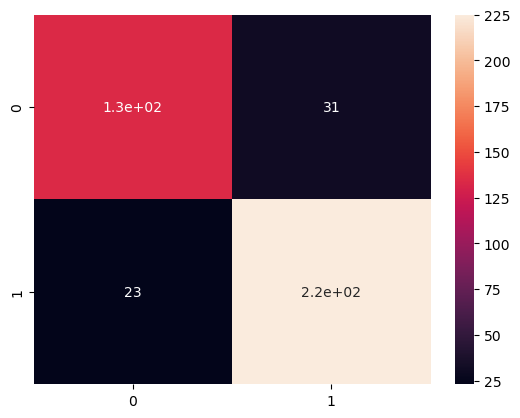

Accuracy: 0.8692493946731235
F1: 0.8928571428571429


In [23]:


X = df_resampled.drop('Label', axis=1)
y = df_resampled['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

print(f'Accuracy: {rf.score(X_test, y_test)}')

# Calculate MCC
from sklearn.metrics import matthews_corrcoef, f1_score

f1 = f1_score(y_test, y_pred)
print(f'F1: {f1}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 4/5; 2/25] START bootstrap=False, max_depth=2, max_features=0.16363636363636364, min_samples_leaf=2, min_samples_split=6, n_estimators=53
[CV 1/5; 2/25] START bootstrap=False, max_depth=2, max_features=0.16363636363636364, min_samples_leaf=2, min_samples_split=6, n_estimators=53
[CV 3/5; 1/25] START bootstrap=True, max_depth=16, max_features=0.509090909090909, min_samples_leaf=4, min_samples_split=10, n_estimators=102
[CV 2/5; 2/25] START bootstrap=False, max_depth=2, max_features=0.16363636363636364, min_samples_leaf=2, min_samples_split=6, n_estimators=53
[CV 5/5; 1/25] START bootstrap=True, max_depth=16, max_features=0.509090909090909, min_samples_leaf=4, min_samples_split=10, n_estimators=102
[CV 2/5; 1/25] START bootstrap=True, max_depth=16, max_features=0.509090909090909, min_samples_leaf=4, min_samples_split=10, n_estimators=102
[CV 3/5; 2/25] START bootstrap=False, max_depth=2, max_features=0.16363636363636364, m

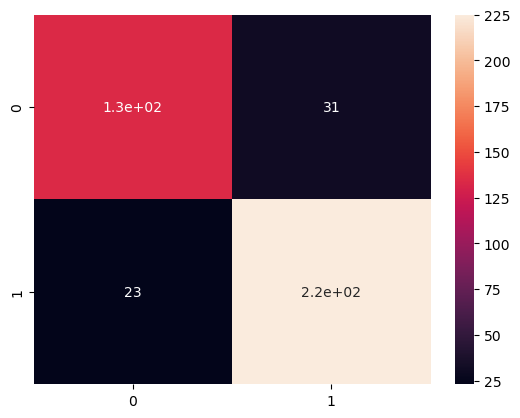

Precision: 0.8789
Recall: 0.9073
Accuracy: 0.8692493946731235
MCC: 0.7258651178741627
F1: 0.8928571428571429


In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 50, 80, 100, 200, 300],           # Number of trees in the forest
    'max_depth': [None, 2, 4, 6, 8, 12, 20, 30],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'max_features': ['auto', 'sqrt', 'log2']   # Number of features to consider when looking for the best split
}

param_dist = {
    'n_estimators': np.linspace(5, 200, 5, dtype=int),           # Number of trees in the forest
    'max_depth': np.linspace(2, 30, 5, dtype=int),           # Maximum depth of the tree
    'min_samples_split': np.linspace(2, 10, 3, dtype=int),           # Minimum number of samples required to split a node
    'min_samples_leaf': np.linspace(1, 4, 3, dtype=int),             # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'max_features': np.linspace(0.1, 1.0, 100)   # Number of features to consider when looking for the best split
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            scoring='matthews_corrcoef',    # You can choose 'accuracy', 'f1', 'roc_auc', etc.
#                            cv=5,            # 5-fold cross-validation
#                            n_jobs=-1,       # Use all available cores
#                            verbose=20)


# Set up RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=25, cv=5, verbose=20, n_jobs=-1)


# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")


# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Best estimator (RandomForest with best hyperparameters)
best_rf = grid_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')


# Calculate F1 score (MCC-like)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'MCC: {mcc}')
print(f'F1: {f1}')


## 2. XGBoost Regression

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6;

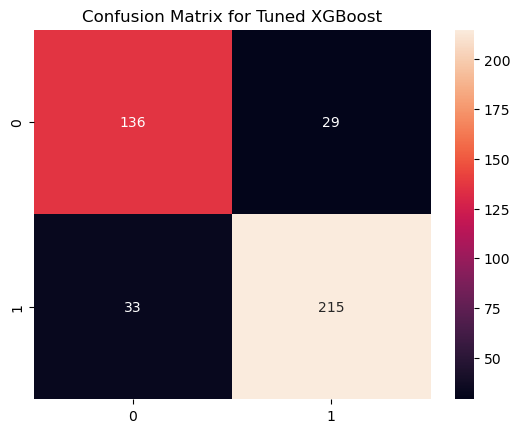

Precision: 0.8811
Recall: 0.8669
Accuracy: 0.8498789346246973
MCC: 0.6885244952646012
F1: 0.8739837398373984


In [33]:
from xgboost import XGBClassifier

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.linspace(100, 1000, 10, dtype=int),
    'max_depth': np.linspace(3, 10, 8, dtype=int),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Print best parameters and score
print("Best parameters:", search.best_params_)


# Use best model to predict
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Tuned XGBoost')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'MCC: {mcc}')
print(f'F1: {f1}')



## 3. SVM

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, gamma=0.010101010101010102, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, gamma=0.01010101010101010

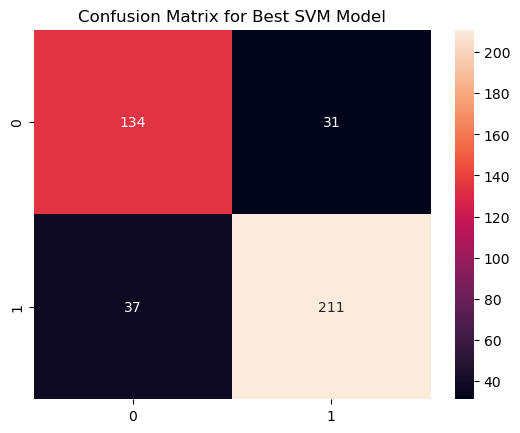

Precision: 0.8719
Recall: 0.8508
Accuracy: 0.8353510895883777
F1 Score: 0.8612244897959184


In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC  # Import the SVM classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Step 3: Set up the SVM classifier and the parameter grid for GridSearchCV
svm = SVC()

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.01,0.1, 0.5, 1, 10, 100],               # Regularization parameter
    'gamma': np.linspace(0, 1, 100),  # Kernel coefficient
    'kernel': ['linear', 'rbf']            # Kernel types
}
    

# Step 4: Set up GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Step 5: Fit the model to the training data with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Step 6: Get the best estimator and print the best parameters
best_svm = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')
print("Best cross-validation score:", grid_search.best_score_)

# Step 7: Use the best model to predict on the test data
y_pred = best_svm.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best SVM Model')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_svm.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


## 4. Logistic Regression

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2

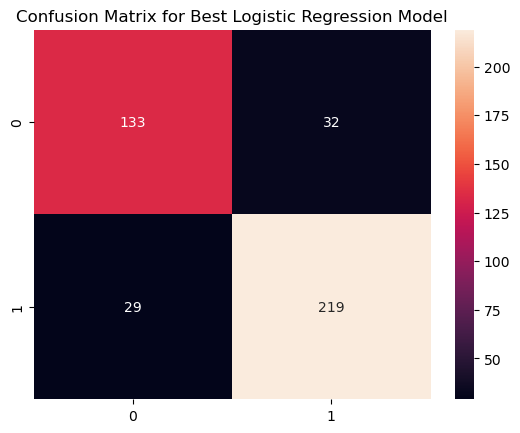

Precision: 0.8725
Recall: 0.8831
Accuracy: 0.8523002421307506
F1 Score: 0.8777555110220441


In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Set up the Logistic Regression classifier and the parameter grid for GridSearchCV
lr = LogisticRegression(max_iter=2000)

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],        # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization types
    'solver': ['saga','liblinear'],                     # Solver for 'elasticnet' regularization
}

# Step 4: Set up GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Step 5: Fit the model to the training data with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)

# Step 6: Get the best estimator and print the best parameters
best_lr = grid_search.best_estimator_


# Step 7: Use the best model to predict on the test data
y_pred = best_lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_lr.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

## 5. Decision Trees 

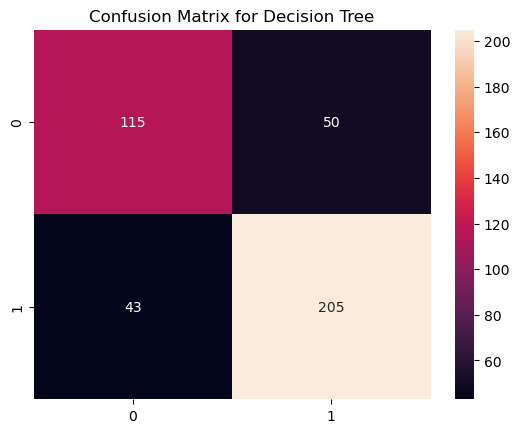

Accuracy: 0.774818401937046
F1 Score: 0.8151093439363817


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Step 3: Initialize and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Step 4: Evaluate the Decision Tree classifier
y_pred = dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Decision Tree')
plt.show()



# Print Accuracy
accuracy = dt.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Average score for Fold 1: 0.7945
Average score for Fold 2: 0.8499
Average score for Fold 3: 0.8558
Average score for Fold 4: 0.8070
Average score for Fold 5: 0.8600
Best cross-validation score: 0.8564
Standard deviation of the best score: 0.0307
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


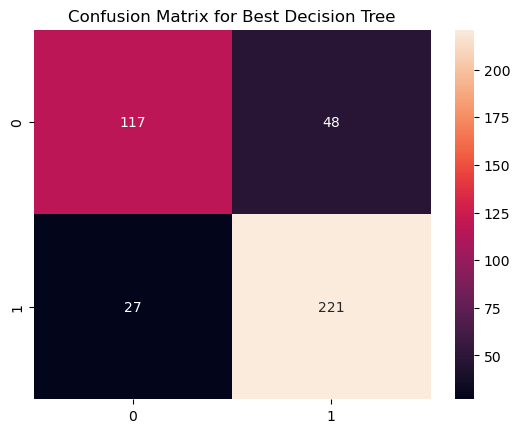

Precision: 0.8216
Recall: 0.8911
Accuracy: 0.8184019370460048
F1 Score: 0.8549323017408124
MCC: 0.6169086312251217


In [30]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, 
                          param_grid=param_grid,
                          cv=5,
                          scoring='f1',
                          n_jobs=-1,
                          verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)


# Get best model
best_dt = grid_search.best_estimator_

# Make predictions with best model
y_pred = best_dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best Decision Tree')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_dt.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calculate and print Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')